In [1]:
import matplotlib
matplotlib.rcParams.update({'text.usetex': False,
                            "svg.fonttype": 'none'})
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import scipy.sparse
from matplotlib import pyplot as plt

In [90]:
ad=sc.read('../../zenodo_repository/data_consolidated.h5ad')

In [91]:
ad_epi = ad[ad.obs['cell_type_coarse'] == 'Epithelial cell']
ad_epi

View of AnnData object with n_obs × n_vars = 39168 × 29641
    obs: 'sample', 'sample_origin', 'patient', 'MS_status', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'CCISM_call', 'CCISM_score', 'numbat_call', 'numbat_score', 'inferCNV_call', 'iCMS_call', 'consensus_call', 'cell_type_epi', 'cytotrace_pseudotime', 'louvain', 'cell_type_coarse', 'cell_type_fine'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCISM_call_colors', 'MS_status_colors', 'cell_type_epi_colors', 'consensus_call_colors', 'iCMS_call_colors', 'inferCNV_call_colors', 'louvain_colors', 'numbat_call_colors', 'patient_colors', 'sample_colors', 'sample_origin_colors'
    obsm: 'X_diffmap_epi', 'X_umap_all', 'X_umap_epi'

In [5]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = '8'

In [8]:
fig = sc.pl.embedding(ad, 
                      basis='umap_epi',
                      color=['consensus_call'], 
                      ncols=1, legend_loc='right margin', size = 2,
                      title = '', frameon = False, return_fig=True)

In [94]:
ad_epi.layers['counts']=ad_epi.raw.X
del ad_epi.raw

In [27]:
sc.tl.rank_genes_groups(ad_epi, groupby='louvain')

In [28]:
sc.tl.filter_rank_genes_groups(ad_epi)

In [36]:
cluster9_genes = pd.DataFrame(ad_epi.uns['rank_genes_groups_filtered']['names'])['9'].dropna()[:10]

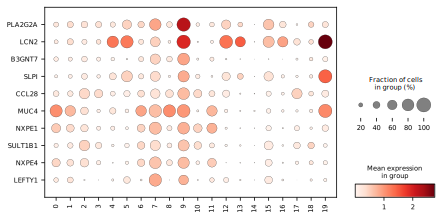

In [39]:
fig=sc.pl.dotplot(ad_epi, cluster9_genes, groupby='louvain',swap_axes=True,show=False,return_fig=True,figsize=(7,3.5))
fig.savefig('cluster9_markers.svg')
fig

In [74]:
sc.get.rank_genes_groups_df(ad_epi,group=None, key='rank_genes_groups_filtered').dropna().groupby('group').head(10).to_csv('epi_louvain_markers.csv')

In [85]:
ad_epi.obs['consensus_call'].cat.categories

Index(['genomically_tumour', 'no confident assignment', 'genomically_normal',
       'normal'],
      dtype='object')

In [103]:
ad_epi.obs['consensus_call']=ad_epi.obs['consensus_call'].cat.add_categories(['normal'])
ad_epi.obs['consensus_call'][ad_epi.obs['consensus_call'].isnull()]='normal'

In [86]:
sc.tl.rank_genes_groups(ad_epi, groupby='consensus_call')
sc.tl.filter_rank_genes_groups(ad_epi)
sc.get.rank_genes_groups_df(ad_epi,group=['genomically_tumour', 'genomically_normal', 'normal'], 
                            key='rank_genes_groups_filtered').dropna().groupby('group').head(20).to_csv('epi_consensus_call_markers.csv')

In [43]:
df=ad.obs[(ad_epi.obs['consensus_call']=='genomically_normal') & (ad.obs['louvain']=='9')].groupby('cell_type_epi').size().drop('Tumour-like',axis=0).reset_index()
#colors=pd.Series(ad.uns['Uhlitz_scANVI_noTC_colors'],index=ad.obs['Uhlitz_scANVI_noTC'].cat.categories)

/tmp/ipykernel_229756/1764004686.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=ad.obs[(ad_epi.obs['consensus_call']=='genomically_normal') & (ad.obs['louvain']=='9')].groupby('cell_type_epi').size().drop('Tumour-like',axis=0).reset_index()


In [89]:
ad_epi.raw

In [105]:
df={}
for sample in ad_epi.obs['sample'].unique():
    for consensus_call in ['genomically_normal','normal']:
        take=(ad_epi.obs['sample']==sample) & (ad_epi.obs['consensus_call']==consensus_call) & (ad_epi.obs['cell_type_epi']=='Stem')
        if take.sum() >= 10:
            tmp=ad_epi[take]
            df[sample+'_'+consensus_call]=pd.Series(tmp.layers['counts'].sum(0).A1,index=tmp.var_names)
        
df=pd.DataFrame.from_dict(df)
df.head()

p020n_normal  p021n_normal  p020t_genomically_normal  \
OR4F5                0.0           0.0                       0.0   
AL627309.1           1.0           0.0                       0.0   
AL627309.3           0.0           0.0                       0.0   
AL627309.4           0.0           0.0                       0.0   
AL732372.1           0.0           0.0                       0.0   

            p007n_normal  p008n_normal  p009n1_normal  p009n2_normal  \
OR4F5                0.0           0.0            0.0            0.0   
AL627309.1           0.0           1.0            1.0            0.0   
AL627309.3           0.0           0.0            0.0            0.0   
AL627309.4           0.0           0.0            0.0            0.0   
AL732372.1           0.0           0.0            0.0            0.0   

            p013n_normal  p014n_normal  p016n_normal  \
OR4F5                0.0           0.0           0.0   
AL627309.1           0.0           0.0           1.0   
AL627309.3           0.0           1.0           0.0   
AL627309.4           0.0           0.0           0.0   
AL732372.1           0.0           0.0           0.0   

            p007t_genomically_normal  p009t1_genomically_normal  \
OR4F5                            0.0                        0.0   
AL627309.1                       0.0                        1.0   
AL627309.3                       0.0                        0.0   
AL627309.4                       0.0                        0.0   
AL732372.1                       0.0                        0.0   

            p009t2_genomically_normal  p013t_genomically_normal  \
OR4F5                             0.0                       0.0   
AL627309.1                        1.0                       0.0   
AL627309.3                        0.0                       0.0   
AL627309.4                        1.0                       0.0   
AL732372.1                        0.0                       0.0   

            p014t_genomically_normal  p016t_genomically_normal  \
OR4F5                            0.0                       0.0   
AL627309.1                       0.0                       2.0   
AL627309.3                       0.0                       1.0   
AL627309.4                       0.0                       0.0   
AL732372.1                       0.0                       0.0   

            p026t_genomically_normal  
OR4F5                            0.0  
AL627309.1                       0.0  
AL627309.3                       0.0  
AL627309.4                       0.0  
AL732372.1                       0.0

In [97]:
%load_ext rpy2.ipython

In [110]:
%%R -i df -o res

library(DESeq2)
library(dplyr)
dds <- DESeqDataSetFromMatrix(countData = df, 
                              colData = DataFrame(donor=gsub('(p0[0-9]*).*','\\1',colnames(df)),
                                                  type=ifelse(grepl('genomically_normal',colnames(df)),
                                                              'genomically_normal','normal'),
                                                  row.names=colnames(df)),
                              design=~donor + type)
dds <- estimateSizeFactors(dds, type='poscounts')
dds <- DESeq(dds)
  
res <- lfcShrink(dds,
                 contrast=c('type','genomically_normal','normal'),
                 type='normal',
                 format="DataFrame") %>%
    as.data.frame() %>%
    tibble::rownames_to_column('gene_name') %>%
    dplyr::filter(!is.na(log2FoldChange),!is.na(pvalue))

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    combine


R[write to console]: The following object is masked from ‘package:matrixStats’:

    count


R[write to console]: The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:GenomeInfoDb’:

    intersect


R[write to console]: The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from

In [126]:
%%R -i res -w 700 -h 500 -r 200

plot_theme_font_size = function(fontsize = 8){
    plot_theme =  theme(title = element_text(size = fontsize, family = "dajavu sans", colour = 'black', hjust = 0.5),
                   axis.title = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   axis.text = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   legend.title =  element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   legend.text=element_text(size=fontsize, family = "dajavu sans", colour = 'black'),
                   text = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   strip.text = element_text(size = fontsize, family = "dajavu sans", colour = 'black'),
                   plot.margin = margin(0,0,0,0,"cm")) 
    plot_theme
}

library(ggplot2)
library(ggrepel)
ggplot(res, aes(x=log2FoldChange, y=-log10(pvalue), color=padj < .05)) + 
geom_point(size=.5)+
geom_label_repel(data=res %>% dplyr::slice_min(padj, n=20),
               aes(label=gene_name),
               segment.size=.25, segment.alpha=.5, size=2,
                 label.padding=unit(.1,'mm'),
                 label.size=0) +
theme_classic() +
scale_color_manual(values=c('black','red')) +
theme(legend.position='none') +
labs(x='log2 fold change', y='-log10 p-value') +
plot_theme_font_size()

ggsave(file="DE_stem_cells_genomically_normal_vs_normal.svg", width = 8, height = 6, units = "cm", dpi = 300)

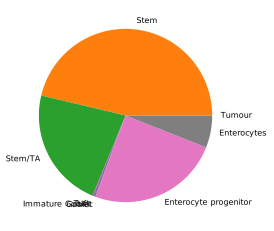

In [45]:
fig=plt.figure(figsize=(4,4))
plt.pie(df[0], labels=df['cell_type_epi']);#, colors=colors.loc[df['Uhlitz_scANVI_noTC']]);
#fig.savefig('cluster9_celltypes.svg')

In [23]:
ad.obs[['cell_identity', 'ct_pseudotime', 'Uhlitz_scANVI_noTC', 'louvain','patient']].to_csv("20240202_cytotrace.csv")

In [128]:
%%R 
library(Seurat)
lung <- readRDS('../datasets/anno/')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp

R[write to console]: 
Attaching package: ‘Seurat’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    Assays


